# Aqueduct data 3.0

Todo List: 
- [X] Explore data 
- [X] Zonal statisticts at basin level for the raster datasets
- [X] Convert everything to our current format
- [X] Add categorization and export table as csv
- [X] Rasters visual reclasification 0-5 
- [x] Arid - low water use classification
- [] Migrate data to RW cartoData account.
maybe rework to obtain 2 tables one for the platform and the other one with the data 
    - 

In [26]:
%matplotlib inline
import __future__
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import pandas as pd
import numpy
import geopandas as gpd
import rasterio
import fiona
from rasterio.mask import mask
from rasterio.plot import show
from rasterstats import zonal_stats
from math import log, ceil
import os

## [Data status](https://docs.google.com/spreadsheets/d/1U7He0q8KBcOuZBNO_65XuUo_1TxCYVGYiuylESOoIPk/edit)

<img  src="HL5Y510A14UMVLTW6EINVGT83ATDHN25.png"/>

## Data exploration:

##### Arid & low water use:

* Arid : Available Blue Water** : $$ A\color{blue}BWater  <0.03 m/(m^2*year)$$  
* Low water use:  $$waterWithdrawal(WW) < 0.012 m/(m^2*year) $$

*A basin needs to satisfy both (AND) conditions to be masked as Arid AND low water use.*  
\*\* **Available blue water calculation:** $$ A\color{blue}BWater = upstreamRunoff – upstreamConsumption(WN) + localRunoff $$
 


##### Datasets:

* calculatedWS03.csv: Contains the next data attached to it
    * baseline water stress monthly and yearly
* hybas_merged_custom_level6_V01.shp: contains the geometries of HYDRO BASIN level 6.

* rasters:
    * global_droughtseveritystandardisedsoilmoisture_5min_1960-2014.tif
    * global_droughtseveritystandardisedstreamflow_5min_1960-2014.tif
    * global_interannualvariabilitywatersupply_5min_1960-2014.tif
    * global_q1seasonalvariabilitywatersupply_5min_1960-2014.tif
    * global_q2seasonalvariabilitywatersupply_5min_1960-2014.tif
    * global_q3seasonalvariabilitywatersupply_5min_1960-2014.tif
    * global_q4seasonalvariabilitywatersupply_5min_1960-2014.tif


### Baseline water stress, Yearly and monthly

In [2]:
base_path=os.getcwd().split('/work')[0]
data_path='/work/data/aqueduct/data_source/aqueduct/v3/toAlicia/calculatedWS03.csv'
inData = pd.read_csv(base_path+data_path)

In [3]:
inData.head(2)

,PFAF_ID,Unnamed: 0,Unnamed: 0.1,HYBAS_ID,NEXT_DOWN,NEXT_SINK,MAIN_BAS,DIST_SINK,DIST_MAIN,SUB_AREA,...,upstream_sum_volumem3_TotWW_monthY2014M11,upstream_sum_volumem3_TotWN_monthY2014M11,local_sum_volumem3_Runoff_monthY2014M11,ws_monthY2014M11,local_sum_volumem3_TotWW_monthY2014M12,local_sum_volumem3_TotWN_monthY2014M12,upstream_sum_volumem3_TotWW_monthY2014M12,upstream_sum_volumem3_TotWN_monthY2014M12,local_sum_volumem3_Runoff_monthY2014M12,ws_monthY2014M12
0,111011,0,0,1060000010,0,1.060000e+09,1.060000e+09,0.0,0.0,1890.8,...,0.0,0.0,69477.380838,73.173082,5.062878e+06,2.354598e+06,0.0,0.0,81085.620721,62.438667
1,111012,1,1,1060000100,0,1.060000e+09,1.060000e+09,0.0,0.0,2925.9,...,0.0,0.0,29361.957127,23.245953,6.820849e+05,2.812766e+05,0.0,0.0,35478.575166,19.225262


In [4]:
inData.shape

(16397, 623)

In [5]:
print(inData.columns.values)

['PFAF_ID' 'Unnamed: 0' 'Unnamed: 0.1' 'HYBAS_ID' 'NEXT_DOWN' 'NEXT_SINK'
 'MAIN_BAS' 'DIST_SINK' 'DIST_MAIN' 'SUB_AREA' 'UP_AREA' 'ENDO' 'COAST'
 'ORDER_' 'SORT' 'Upstream_HYBAS_IDs' 'Upstream_PFAF_IDs' 'PfafIDarea30sm2'
 'countarea30sm2' 'meanarea30sm2' 'PfafIDDomWN_monthY2014M01'
 'countDomWN_monthY2014M01' 'meanDomWN_monthY2014M01'
 'PfafIDDomWN_monthY2014M02' 'countDomWN_monthY2014M02'
 'meanDomWN_monthY2014M02' 'PfafIDDomWN_monthY2014M03'
 'countDomWN_monthY2014M03' 'meanDomWN_monthY2014M03'
 'PfafIDDomWN_monthY2014M04' 'countDomWN_monthY2014M04'
 'meanDomWN_monthY2014M04' 'PfafIDDomWN_monthY2014M05'
 'countDomWN_monthY2014M05' 'meanDomWN_monthY2014M05'
 'PfafIDDomWN_monthY2014M06' 'countDomWN_monthY2014M06'
 'meanDomWN_monthY2014M06' 'PfafIDDomWN_monthY2014M07'
 'countDomWN_monthY2014M07' 'meanDomWN_monthY2014M07'
 'PfafIDDomWN_monthY2014M08' 'countDomWN_monthY2014M08'
 'meanDomWN_monthY2014M08' 'PfafIDDomWN_monthY2014M09'
 'countDomWN_monthY2014M09' 'meanDomWN_monthY2014M09'
 '

* Columns to be keept for the data visualization and to be transform into indicators table:   

In [6]:
column_list = ['PFAF_ID','ws_yearY2014']
for month in list(range(1,13)):
    column_list.append("ws_monthY2014M%02d" % (month))
column_list

['PFAF_ID',
 'ws_yearY2014',
 'ws_monthY2014M01',
 'ws_monthY2014M02',
 'ws_monthY2014M03',
 'ws_monthY2014M04',
 'ws_monthY2014M05',
 'ws_monthY2014M06',
 'ws_monthY2014M07',
 'ws_monthY2014M08',
 'ws_monthY2014M09',
 'ws_monthY2014M10',
 'ws_monthY2014M11',
 'ws_monthY2014M12']

* Columns to use as a Arid and low water use

In [7]:
col_list = ['PFAF_ID','local_sum_volumem3_TotWW_yearY2014','local_sum_volumem3_Runoff_yearY2014', 'upstream_sum_volumem3runoff_annua','upstream_sum_volumem3_TotWN_yearY2014']
col_list

['PFAF_ID',
 'local_sum_volumem3_TotWW_yearY2014',
 'local_sum_volumem3_Runoff_yearY2014',
 'upstream_sum_volumem3runoff_annua',
 'upstream_sum_volumem3_TotWN_yearY2014']

### Geometries

In [8]:
geoInData = gpd.read_file(base_path+'/work/data/aqueduct/data_source/aqueduct/v3/toAlicia/shape/unionADM01Hybas6V02WHYMAPV05.shp')

In [9]:
geoInData.head(2)

,AQ30ID,AqID,ISO,PFAF_ID,geometry,provinceID
0,1,2501,,0,(POLYGON ((-37.60435027558478 -4.6124528796255...,0
1,2,2517,,0,(POLYGON ((-35.51175937859333 -5.1496952318965...,0


In [ ]:
#geoInData.plot()

In [10]:
for column in geoInData.columns.values:
    print(column)

AQ30ID
AqID
ISO
PFAF_ID
geometry
provinceID


Keep all columns; 

### Pixel level datasets: 

* drought severity:
    * soil moisture
    * streamflow
* interannual variability
* seasonal variability
    * q1
    * q2
    * q3
    * q4

In [23]:
"""
Tiff config object:
[
{'dataset': , 'indicator': , 
'period': , 'period_value': , 
'year': 2014, 
'data_type': 'absolute', 
'scenario': 'historic'}
]
"""
baseLocation = base_path+'/work/data/aqueduct/data_source/aqueduct/v3/pixelIndicatorsAlicia/' 

tifss= [{'dataset': "global_droughtseveritystandardisedsoilmoisture_5min_1960-2014.tif", 'indicator': 'drought_severity_soil', 'period': 'year', 'period_value': None, 'year': 2014, 'data_type': 'absolute', 'scenario': 'historic'},
        {'dataset': "global_droughtseveritystandardisedstreamflow_5min_1960-2014.tif", 'indicator': 'drought_severity_flow', 'period': 'year', 'period_value': None, 'year': 2014, 'data_type': 'absolute', 'scenario': 'historic'},
        {'dataset': "global_interannualvariabilitywatersupply_5min_1960-2014.tif", 'indicator': 'interannual_variability', 'period': 'year', 'period_value': None, 'year': 2014, 'data_type': 'absolute', 'scenario': 'historic'},
        {'dataset': "global_q1seasonalvariabilitywatersupply_5min_1960-2014.tif", 'indicator': 'seasonal_variability', 'period': 'quarter', 'period_value': 1, 'year': 2014, 'data_type': 'absolute', 'scenario': 'historic'},
        {'dataset': "global_q2seasonalvariabilitywatersupply_5min_1960-2014.tif", 'indicator': 'seasonal_variability', 'period': 'quarter', 'period_value': 2, 'year': 2014, 'data_type': 'absolute', 'scenario': 'historic'},
        {'dataset': "global_q3seasonalvariabilitywatersupply_5min_1960-2014.tif", 'indicator': 'seasonal_variability', 'period': 'quarter', 'period_value': 3, 'year': 2014, 'data_type': 'absolute', 'scenario': 'historic'},
        {'dataset': "global_q4seasonalvariabilitywatersupply_5min_1960-2014.tif", 'indicator': 'seasonal_variability', 'period': 'quarter', 'period_value': 4, 'year': 2014, 'data_type': 'absolute', 'scenario': 'historic'}
] 

### global_droughtseveritystandardisedsoilmoisture_5min_1960-2014

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -9999.0, 'width': 4320, 'height': 2160, 'count': 1, 'crs': CRS({'init': 'epsg:4326'}), 'transform': Affine(0.0833333309780367, 0.0, -179.99999491255934,
       0.0, -0.0833333309780367, 90.00000254430942), 'tiled': False, 'compress': 'lzw', 'interleave': 'band'}
[[-- -- -- ..., -- -- --]
 [-- -- -- ..., -- -- --]
 [-- -- -- ..., -- -- --]
 ..., 
 [0.0 0.0 0.0 ..., 0.0 0.0 0.0]
 [0.0 0.0 0.0 ..., 0.0 0.0 0.0]
 [0.0 0.0 0.0 ..., 0.0 0.0 0.0]]


/Users/alicia/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


### global_droughtseveritystandardisedstreamflow_5min_1960-2014

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -9999.0, 'width': 4320, 'height': 2160, 'count': 1, 'crs': CRS({'init': 'epsg:4326'}), 'transform': Affine(0.0833333309780367, 0.0, -179.99999491255934,
       0.0, -0.0833333309780367, 90.00000254430942), 'tiled': False, 'compress': 'lzw', 'interleave': 'band'}
[[-- -- -- ..., -- -- --]
 [-- -- -- ..., -- -- --]
 [-- -- -- ..., -- -- --]
 ..., 
 [0.0 0.0 0.0 ..., 0.0 0.0 0.0]
 [0.0 0.0 0.0 ..., 0.0 0.0 0.0]
 [0.0 0.0 0.0 ..., 0.0 0.0 0.0]]


### global_interannualvariabilitywatersupply_5min_1960-2014

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -9999.0, 'width': 4320, 'height': 2160, 'count': 1, 'crs': CRS({'init': 'epsg:4326'}), 'transform': Affine(0.0833333309780367, 0.0, -179.99999491255934,
       0.0, -0.0833333309780367, 90.00000254430942), 'tiled': False, 'compress': 'lzw', 'interleave': 'band'}
[[-- -- -- ..., -- -- --]
 [-- -- -- ..., -- -- --]
 [-- -- -- ..., -- -- --]
 ..., 
 [0.0 0.0 0.0 ..., 0.0 0.0 0.0]
 [0.0 0.0 0.0 ..., 0.0 0.0 0.0]
 [0.0 0.0 0.0 ..., 0.0 0.0 0.0]]


### global_q1seasonalvariabilitywatersupply_5min_1960-2014

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -9999.0, 'width': 4320, 'height': 2160, 'count': 1, 'crs': CRS({'init': 'epsg:4326'}), 'transform': Affine(0.0833333309780367, 0.0, -179.99999491255934,
       0.0, -0.0833333309780367, 90.00000254430942), 'tiled': False, 'compress': 'lzw', 'interleave': 'band'}
[[-- -- -- ..., -- -- --]
 [-- -- -- ..., -- -- --]
 [-- -- -- ..., -- -- --]
 ..., 
 [0.0 0.0 0.0 ..., 0.0 0.0 0.0]
 [0.0 0.0 0.0 ..., 0.0 0.0 0.0]
 [0.0 0.0 0.0 ..., 0.0 0.0 0.0]]


### global_q2seasonalvariabilitywatersupply_5min_1960-2014

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -9999.0, 'width': 4320, 'height': 2160, 'count': 1, 'crs': CRS({'init': 'epsg:4326'}), 'transform': Affine(0.0833333309780367, 0.0, -179.99999491255934,
       0.0, -0.0833333309780367, 90.00000254430942), 'tiled': False, 'compress': 'lzw', 'interleave': 'band'}
[[-- -- -- ..., -- -- --]
 [-- -- -- ..., -- -- --]
 [-- -- -- ..., -- -- --]
 ..., 
 [0.0 0.0 0.0 ..., 0.0 0.0 0.0]
 [0.0 0.0 0.0 ..., 0.0 0.0 0.0]
 [0.0 0.0 0.0 ..., 0.0 0.0 0.0]]


### global_q3seasonalvariabilitywatersupply_5min_1960-2014

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -9999.0, 'width': 4320, 'height': 2160, 'count': 1, 'crs': CRS({'init': 'epsg:4326'}), 'transform': Affine(0.0833333309780367, 0.0, -179.99999491255934,
       0.0, -0.0833333309780367, 90.00000254430942), 'tiled': False, 'compress': 'lzw', 'interleave': 'band'}
[[-- -- -- ..., -- -- --]
 [-- -- -- ..., -- -- --]
 [-- -- -- ..., -- -- --]
 ..., 
 [0.0 0.0 0.0 ..., 0.0 0.0 0.0]
 [0.0 0.0 0.0 ..., 0.0 0.0 0.0]
 [0.0 0.0 0.0 ..., 0.0 0.0 0.0]]


### global_q4seasonalvariabilitywatersupply_5min_1960-2014

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -9999.0, 'width': 4320, 'height': 2160, 'count': 1, 'crs': CRS({'init': 'epsg:4326'}), 'transform': Affine(0.0833333309780367, 0.0, -179.99999491255934,
       0.0, -0.0833333309780367, 90.00000254430942), 'tiled': False, 'compress': 'lzw', 'interleave': 'band'}
[[-- -- -- ..., -- -- --]
 [-- -- -- ..., -- -- --]
 [-- -- -- ..., -- -- --]
 ..., 
 [0.0 0.0 0.0 ..., 0.0 0.0 0.0]
 [0.0 0.0 0.0 ..., 0.0 0.0 0.0]
 [0.0 0.0 0.0 ..., 0.0 0.0 0.0]]


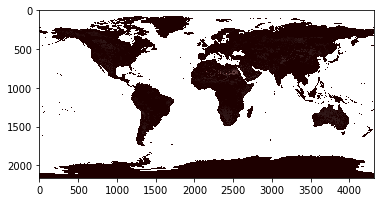

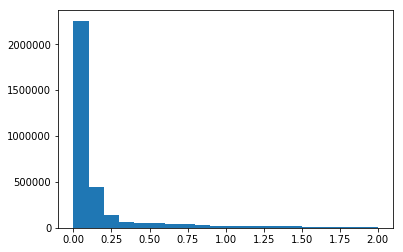

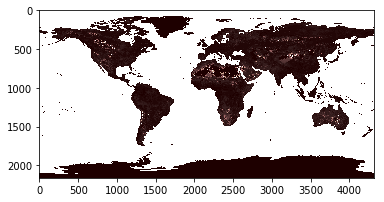

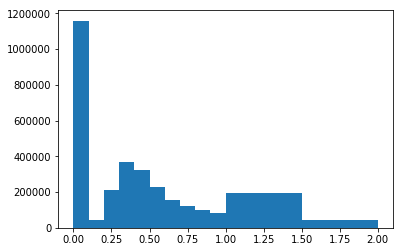

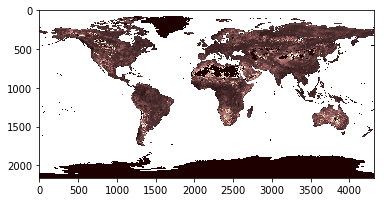

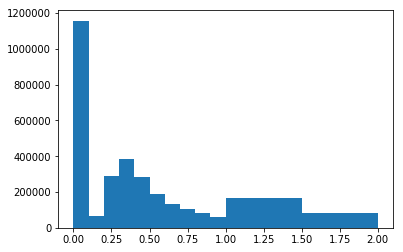

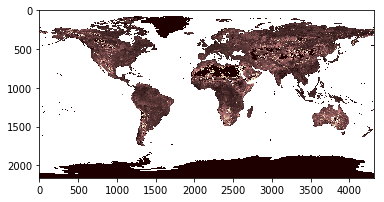

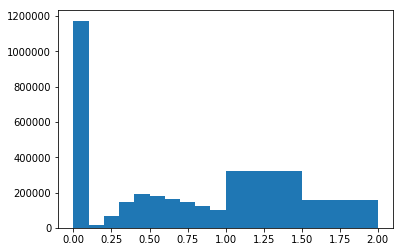

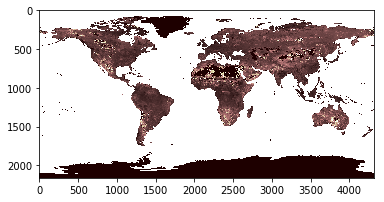

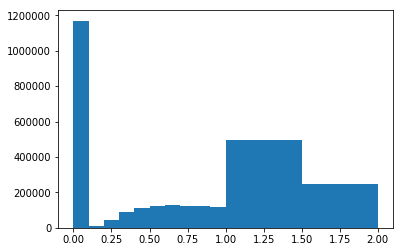

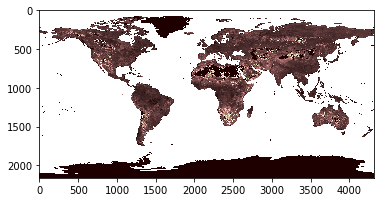

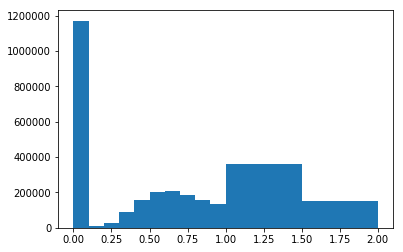

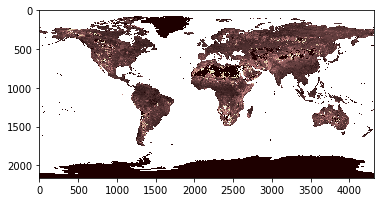

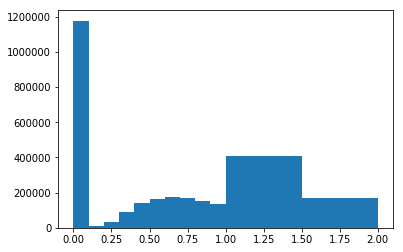

In [39]:
n = 1
for image in tifss:
    with rasterio.open(baseLocation+image['dataset']) as tif:
        display(Markdown('### '+image['dataset'].split('.')[0]))
        print(tif.profile)
        rasterData=tif.read(1, masked=True)
        print(rasterData)
        profile = tif.profile
        f1 = plt.figure(n)
        plt.imshow(rasterData[:,:],  cmap='pink')
        f1.show()
        f2= plt.figure(n+1)
        plt.hist(rasterData.compressed().ravel(),bins=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,1.5,2])
        f2.show()
    n=n+2
    
    

## Zonal statistics, generate subasin level stats

What's are the stats that i need to perform? The mean  


In [15]:
def zonal_statistics(baseLocation, geomDatasets, cfgTif):
    dataset=[]
    with rasterio.open(baseLocation + cfgTif['dataset']) as tif:
        rasterData=tif.read(1)
        profile = tif.profile
    for index, row in geoInData.iterrows():
        mean = zonal_stats(row['geometry'], rasterData, stats=['mean'], band=1, all_touched=True,raster_out=False, affine=profile['transform'], nodata=profile['nodata'])
        dataset.append({'indicator': cfgTif['indicator'], 
                        'value': mean[0]['mean'], 
                        'basinid':row['PFAF_ID'],
                        'period': cfgTif['period'], 
                        'period_value': cfgTif['period_value'], 
                        'year': cfgTif['year'], 
                        'data_type': cfgTif['data_type'], 
                        'scenario': cfgTif['scenario']
                       })
    return pd.DataFrame(dataset, columns=dataset[0].keys())




## Baseline Water stress reconfiguration

In [16]:
def unpivot(frame):
    mapK={
        'ws':'water_stess'
    }
    N, K = frame.shape
    indicator = [mapK[i.split('_')[0]] for  i in frame.columns]
    period = [i.split('_')[1].split('Y')[0] for  i in frame.columns]
    period_value = [int(i.split('_')[1].split('Y')[1].split('M')[1]) if len(i.split('_')[1].split('Y')[1].split('M')) > 1 else None for  i in frame.columns]
    year= [int(i.split('_')[1].split('Y')[1].split('M')[0]) for  i in frame.columns]

    
    data = {'value' : frame.values.ravel('F'),
            'indicator' : numpy.array(indicator).repeat(N),
            'basinid' : numpy.tile(numpy.asarray(frame.index), K),
            'period': numpy.array(period).repeat(N),
            'period_value': numpy.asarray(period_value).repeat(N),
            'year': numpy.array(year).repeat(N),
            'data_type': 'absolute',
            'scenario': 'historic'
           }
    return pd.DataFrame(data, columns=['basinid', 'indicator', 'period','period_value','year','data_type','scenario','value'])


## Arid and low water use basins

In [17]:
def Blue_water(x):
    '''
    Will generate Available blue water column 
    '''  
    return x['upstream_sum_volumem3runoff_annua']-x['upstream_sum_volumem3_TotWN_yearY2014']+x['local_sum_volumem3_Runoff_yearY2014']

def arLoWa(x):
    '''
    Will generate a boolean column that will indicate if that geometry is arid or not 
    '''  
    if x['local_sum_volumem3_TotWW_yearY2014']<0.012 and x['ABWater']<0.03:
        return True
    else:
        return False

def arid(dataframe):
    '''
    Will return f dataframe with ['PFAF_ID', 'is_AridLoW'] columns
    '''
    dataframe['ABWater']=dataframe.apply(Blue_water, axis=1)
    dataframe['is_AridLoW']=dataframe.apply(arLoWa, axis=1)
    
    return dataframe[['PFAF_ID', 'is_AridLoW']]
    
    
    
    

In [18]:
wv_arid = arid(inData[col_list])

/Users/alicia/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/alicia/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [19]:
wv_arid.tail(5)

,PFAF_ID,is_AridLoW
16392,312042,False
16393,312016,False
16394,312804,False
16395,322660,False
16396,312670,False


In [20]:
wv_arid.groupby('is_AridLoW')['is_AridLoW'].count()

is_AridLoW
False    16033
True       364
Name: is_AridLoW, dtype: int64

In [21]:
arid_list=wv_arid.loc[wv_arid['is_AridLoW']==True]['PFAF_ID'].values

## All together to rule them

In [24]:
outData=[]
for dataset in tifss:
    outData.append(zonal_statistics(baseLocation, geoInData, dataset))
outData.append(unpivot(inData[column_list].set_index(['PFAF_ID'])))
f = pd.concat(outData)

## Categorization computation 

* **Baseline water stress:** $$x = \frac{{LN([rawValue])-LN(0.1)}}{LN(2) } + 1$$
    - 0.1 represents minimum interest value  
    - 2 represent the maximum interest value  
    ##### Arid & low water use:

    * Arid : Available Blue Water** : $$ A\color{blue}BWater  <0.03 m/(m^2*year)$$  
    * Low water use:  $$waterWithdrawal(WW) < 0.012 m/(m^2*year) $$

    *A basin needs to satisfy both (AND) conditions to be masked as Arid AND low water use.*  
    \*\* **Available blue water calculation:** $$ A\color{blue}BWater = upstreamRunoff – upstreamConsumption(WN) + localRunoff $$
 
* **Drought severity:** $$x = 5\frac{{[rawValue]-min}}{max-min} + 1$$
* **Interannual variability:** $$x = 5\frac{{[rawValue]-min}}{max-min} + 1$$
* **Seasonal variability:** $$x = 5\frac{{[rawValue]-min}}{max-min} + 1$$


In [28]:
f.head(2)

,basinid,data_type,indicator,period,period_value,scenario,value,year
0,0,absolute,drought_severity_soil,year,None,historic,0.265479,2014
1,0,absolute,drought_severity_soil,year,None,historic,0.042162,2014


In [29]:

def indicatorStc(frame):
    '''
    Calculates the basic statistics needed for categorization definition
    '''
    indicator_stats = {}
    for indicator in frame.indicator.unique():
        subsample = frame[frame['indicator'] == indicator]
        indicator_stats[indicator]={'min':subsample.value.min(),'max':subsample.value.max()}
        print(indicator,': ', indicator_stats[indicator]['min'],', ', indicator_stats[indicator]['max'])
    return indicator_stats

In [32]:
def categorize(row):
    '''
    Categorize the raw data on 0-5 range
    '''
    if row['basinid'] in arid_list:
        return -1
    elif row['indicator']!='water_stess':
        return 5*((row['value']-indicator_stats[row['indicator']]['min'])/(indicator_stats[row['indicator']]['max']-indicator_stats[row['indicator']]['min']))
    elif row['value']>=0.1 and row['value']<=2:
        return (((log(row['value'])-log(0.1))/(log(2)))+1)
    elif row['value']>2:
        return 5.25
    else:
        return 10
    

In [33]:
indicator_stats = indicatorStc(f)
f['cat'] = f.apply(categorize, axis=1)

drought_severity_soil :  0.0 ,  5.70747098658
drought_severity_flow :  0.0 ,  57.9761009216
interannual_variability :  0.0 ,  7.62683010101
seasonal_variability :  0.0 ,  13.0383996964
water_stess :  -3.67572715908e+25 ,  inf


In [34]:
f.head(2)

,basinid,data_type,indicator,period,period_value,scenario,value,year,cat
0,0,absolute,drought_severity_soil,year,None,historic,0.265479,2014,0.232571
1,0,absolute,drought_severity_soil,year,None,historic,0.042162,2014,0.036935


In [35]:
for indicator in f.indicator.unique():
    subsample = f[f['indicator'] == indicator]
    print(indicator,': ', subsample.cat.min(),', ', subsample.cat.max())

drought_severity_soil :  -1.0 ,  5.0
drought_severity_flow :  -1.0 ,  5.0
interannual_variability :  -1.0 ,  5.0
seasonal_variability :  -1.0 ,  5.0
water_stess :  -1.0 ,  10.0


In [36]:
f.to_csv(base_path+'/work/data/aqueduct/dst/aqueduct/v3/water_risk_indicators_v3.csv')

## Raster reclassification

For those indicators that are going to be shown at pixel level on the visualization we need to agreed on a name convention so we can call them independenly and reclasify them following the same categorization formulas used for the basin level data.

* **Drought severity:** $$x = 5\frac{{[rawValue]-min}}{max-min} + 1$$
* **Interannual variability:** $$x = 5\frac{{[rawValue]-min}}{max-min} + 1$$
* **Seasonal variability:** $$x = 5\frac{{[rawValue]-min}}{max-min} + 1$$

In [ ]:
def rCat(x):
    return 5*((x-data['min'])/(data['max']-data['min']))



In [ ]:
tifStats = []
for data in tifss:
    with rasterio.open(baseLocation + data['dataset']) as tif:
        dataset = tif.read(1, masked=True)
        data['min'] = numpy.amin(dataset)
        data['max'] = numpy.amax(dataset)
        tifStats.append(data)
    
#print(tifStats)    
#asdf={x:{'min':[],'max':[]} for x in numpy.unique([x['indicator'] for x in tifss])} 

#for data in tifStats:
#    asdf[data['indicator']]['min'].append(data['min'])
#    asdf[data['indicator']]['max'].append(data['max'])
#asdf
tifStats

In [ ]:
rCat = numpy.vectorize(rCat)
for data in tifStats:
    with rasterio.open(baseLocation + data['dataset']) as tif:
        dataset = tif.read(1, masked=True)
        result_dataset = rCat(dataset)
        profile = tif.profile
        profile['dtype']='uint8'
        profile['compress']='lzw'
        profile['nodata']=255
        fileName = '{0}-{1}-{2}-{3}{4}'.format(data['indicator'],data['scenario'],data['period'],str(data['year']),('-'+str(data['period_value'])) if data['period_value']!= None else '')
        filedir=base_path + '/work/data/aqueduct/dst/aqueduct/v3/' +  fileName
        with rasterio.open(filedir, 'w', **profile) as dst:
            dst.write(result_dataset.astype(profile['dtype']), 1)


## Data Migration from wri-01 account to wri-rw

Carto has an issue with big tables > 1000000 rows tables. In order to ingest
### todolist
- [x] split crops, and crops_geo table
- [] upload it to carto

In [40]:
import requests
import json

In [41]:
url = 'https://wri-rw.carto.com/api/v1/viz/?tag_name=aqueduct&type=&exclude_shared=false&per_page=1000&tags=aqueduct&types=table'
r = requests.get(url)
tableStructure= pd.read_json(json.dumps(r.json()['visualizations']), orient='records')
tableStructure.head(17)



,active_child,active_layer_id,attributions,auth_tokens,children,created_at,description,display_name,external_source,id,...,synchronization,table,tags,title,transition_options,type,updated_at,url,uses_builder_features,version
0,NaN,NaN,None,[],[],2017-06-29 09:11:51,floods per country,NaN,{},2db6482d-fe51-4247-8c5d-0c9994ace908,...,NaN,"{'id': '12036b1e-3d24-494d-9c68-e1645904e6db',...","[water, dashboard, Aqueduct, alicia]",NaN,{'time': 0},table,2017-06-29 09:13:16,https://wri-rw.carto.com/tables/aqueduct_globa...,True,3
1,NaN,NaN,None,[],[],2017-06-01 16:28:02,aqueuduct v3.0 geometry,NaN,{},f3d869d2-3a25-4e4d-a3db-206c6df9ae2b,...,NaN,"{'id': 'fb2f0d31-7f9e-42dd-b3d4-8dd46923c3e0',...","[aqueduct, alicia]",NaN,{'time': 0},table,2017-06-01 16:28:46,https://wri-rw.carto.com/tables/hybas_merged_c...,True,3
2,NaN,NaN,None,[],[],2017-06-01 16:25:48,aqueuduct v3.0 data,NaN,{},9c78a8f5-468f-4616-a567-e93758eb2c52,...,NaN,"{'id': '4ff269f9-0e14-49e2-a018-2ebef8047b4d',...","[aqueduct, alicia]",NaN,{'time': 0},table,2017-06-01 16:27:52,https://wri-rw.carto.com/tables/aqv3,True,3
3,NaN,NaN,None,[],[],2017-06-01 16:25:49,None,NaN,{},b2b20447-283e-4e82-9367-e9c1e4a5b52a,...,NaN,"{'id': 'c25bb692-cb47-4f3a-b4d4-593187e011e7',...","[aqueduct, alicia]",NaN,{'time': 0},table,2017-06-01 16:27:31,https://wri-rw.carto.com/tables/drought_severi...,True,3
4,NaN,NaN,None,[],[],2017-06-01 16:25:48,None,NaN,{},46326c5c-357e-4e34-94bf-7f29c90e597f,...,NaN,"{'id': '717f5d0b-b3bb-4a14-bc4d-4a7e27acafcd',...","[aqueduct, alicia]",NaN,{'time': 0},table,2017-06-01 16:27:24,https://wri-rw.carto.com/tables/seasonal_varia...,True,3
5,NaN,NaN,None,[],[],2017-05-24 11:31:52,aqueduct v2 - MAPSPAM - Marinekko dataset,NaN,{},104c500f-d9b6-491e-bba9-299e347a699e,...,NaN,"{'id': 'adfd52e7-5aac-4aae-83ed-db14720089f5',...","[aqueduct, alicia]",NaN,{'time': 0},table,2017-05-24 11:51:21,https://wri-rw.carto.com/tables/crops_stats,True,3
6,NaN,NaN,None,[],[],2017-05-24 11:31:52,aqueduct v2 - geometries,NaN,{},e5bca5ae-1d28-4166-bf0e-ce91d7e69f62,...,NaN,"{'id': 'f084e530-e941-446f-9d2a-1d48c9c5561f',...","[aqueduct, alicia]",NaN,{'time': 0},table,2017-05-24 11:50:05,https://wri-rw.carto.com/tables/wri_subcatchem...,True,3
7,NaN,NaN,None,[],[],2017-05-24 11:29:52,ifript data,NaN,{},70d45bea-16b3-47e5-9673-f21281a49f8f,...,NaN,"{'id': '33e83d0f-99e6-4601-b0a5-c7f5a4412a4a',...","[Aqueduct, alicia]",NaN,{'time': 0},table,2017-05-24 11:49:28,https://wri-rw.carto.com/tables/combined01_pre...,True,3
8,NaN,NaN,None,[],[],2017-05-24 11:29:41,aqueduct v2 - curate table,NaN,{},a1bd3c81-08bd-4ed4-8e95-9102ce7b13c8,...,NaN,"{'id': 'ad43773d-b8f6-4687-80c8-fcdb4bfa5f6b',...","[aqueduct, alicia]",NaN,{'time': 0},table,2017-05-24 11:49:04,https://wri-rw.carto.com/tables/water_risk_ind...,True,3
9,NaN,NaN,None,[],[],2017-05-24 11:28:44,yield-area stats per crop and per basin,NaN,{},b9bd590d-04a4-4255-a63d-c4272cd76f0f,...,NaN,"{'id': '59407874-5017-422e-a8a5-09a7af9307f5',...","[aqueduct, alicia]",NaN,{'time': 0},table,2017-05-24 11:47:59,https://wri-rw.carto.com/tables/all_crops_stats,True,3


In [ ]:
"""
https://carto.com/docs/carto-engine/import-api/quickstart
"""


def split_table(dataset, name):
    """
    this function splits a table in x datasets to make it uploable to a carto account
    """
    i=1
    dataset_data=[]
    for data in np.array_split(dataset, 1000000):
        split_dataset_name = 'split'+'_'+name+'_'+str(i)+'.csv'
        full_d_path = base_path+'/work/data/aqueduct/dst/aqueduct/v3/'+split_dataset_name
        dataset.to_csv(full_d_path)
        i=i+1
        dataset_data.append({"part_name":split_dataset_name.split('.')[0],"path":full_d_path})
    return {"table_name":name,"parts":dataset_data}
    
    
    
def upload_carto(parts):
    """
    this function will upload a dataset into carto
    """
    
    
def merge_carto(parts):
    """
    this function will merge datasets into carto
    """
    meta_sql = "SELECT * INTO job_result FROM ({{query}}) AS job"
    sql="select {{columns}} from {{datasets}}"